# Transfer Learning with Tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Cam leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

## Download and becoming one with data


In [4]:
# get data(10% of it)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref= zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-06-04 08:18:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:801::201b, 2a00:1450:4001:80e::201b, 2a00:1450:4001:80f::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:801::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160,74M  38,1MB/s    in 4,6s    

2024-06-04 08:18:34 (35,0 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [5]:
# How many images in each folder
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

## Creating data loader

we'll use the `ImageDataGenerator` class to load in our images in batches

In [6]:
# setup data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                            target_size=IMAGE_SHAPE,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

callbacks are extra functionality you can add to your models to be performed during or after training.Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the earlyStopping callback



In [41]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

# Creating models using TensorFlow Hub

we can access pretrained models on: https://tfhub.dev/

we found following feature vector model link on kaggle:
https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2

In [8]:
# Let's compare two folloing models
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/152-feature-vector/2'

efficientnet_url = 'https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2'

In [38]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
print('Tensorflow version:', tf.__version__)
print('Tensorflow Hub version:', hub.__version__)
print('Keras version:', keras.__version__)
# Let's make a create_model() function to create a model from a URL

Tensorflow version: 2.16.1
Tensorflow Hub version: 0.16.1
Keras version: 2.16.0


In [10]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [39]:
# Let's make a create_model() function to create a model from a url
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a keras Sequential model with it.
  
  Args:
  model_url (str):A TensorFlow Hub feature extraction URL.
  num_classes (int):Number of output neurons in output layer, should be equal to number of target classes, default 10.
  
  Returns:
   An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) #define input shape
  
  # Create our own model
  model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [43]:
# create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240604-083922
Epoch 1/5


2024-06-04 08:39:30.536114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 48s 1s/step - loss: 1.9189 - accuracy: 0.3587 - val_loss: 1.0716 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - 29s 1s/step - loss: 0.7847 - accuracy: 0.7533 - val_loss: 0.7986 - val_accuracy: 0.7404
Epoch 3/5
24/24 [==============================] - 29s 1s/step - loss: 0.5454 - accuracy: 0.8267 - val_loss: 0.6836 - val_accuracy: 0.7764
Epoch 4/5
24/24 [==============================] - 29s 1s/step - loss: 0.3956 - accuracy: 0.8893 - val_loss: 0.6453 - val_accuracy: 0.7872
Epoch 5/5
24/24 [==============================] - 29s 1s/step - loss: 0.3308 - accuracy: 0.9213 - val_loss: 0.6293 - val_accuracy: 0.8016


wow!

That is Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we build by hand...
and in a quicker training time and with only 10% of the training examples.

In [46]:
# Let's plot out our lost curves...
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

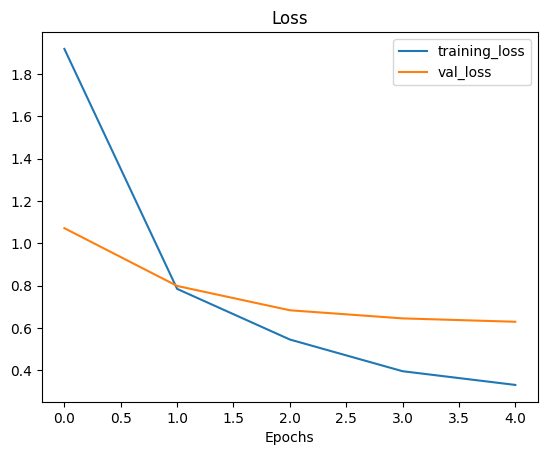

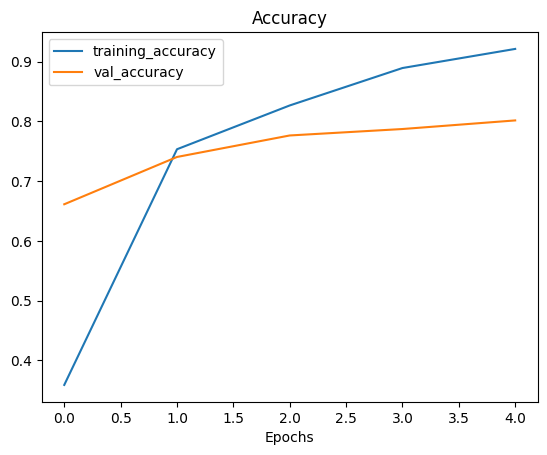

In [47]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [48]:
# create efficientNewt model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])
efficientnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='efficient50V2')])

Saving TensorBoard log files to: tensorflow_hub/efficient50V2/20240604-085307
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 0.2502 - accuracy: 0.9547 - val_loss: 0.6391 - val_accuracy: 0.7916
Epoch 2/5
24/24 [==============================] - 29s 1s/step - loss: 0.2159 - accuracy: 0.9720 - val_loss: 0.6332 - val_accuracy: 0.7952
Epoch 3/5
24/24 [==============================] - 29s 1s/step - loss: 0.1772 - accuracy: 0.9813 - val_loss: 0.5822 - val_accuracy: 0.8084
Epoch 4/5
24/24 [==============================] - 29s 1s/step - loss: 0.1464 - accuracy: 0.9880 - val_loss: 0.6262 - val_accuracy: 0.8020
Epoch 5/5
24/24 [==============================] - 29s 1s/step - loss: 0.1302 - accuracy: 0.9920 - val_loss: 0.5784 - val_accuracy: 0.8192


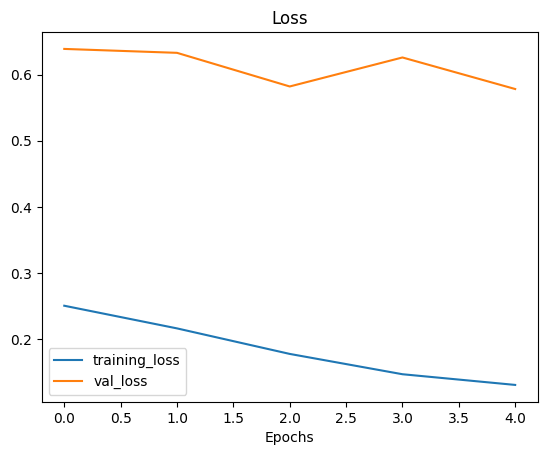

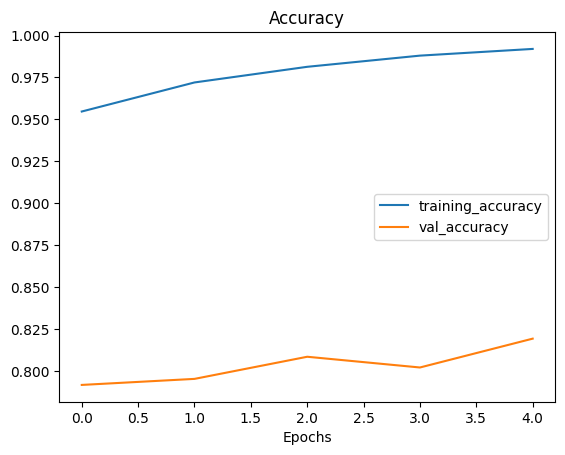

In [49]:
plot_loss_curves(efficientnet_history)

In [50]:
efficientnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [51]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              58331648  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 58352138 (222.60 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


## Different types of transfer learning

* "As is" transfer learning - uising an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* "Feature extraction" transfer learning - use the prelearned patterns of an existing model  (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes)
* "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers) 

## comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experminets are public.

ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.
